In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    
])
train_transform2 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.RandomCrop(224,112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = datasets.ImageFolder('mydata/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('rgb_MNIST/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=get_dataloader_workers())

In [3]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

tensor(0)


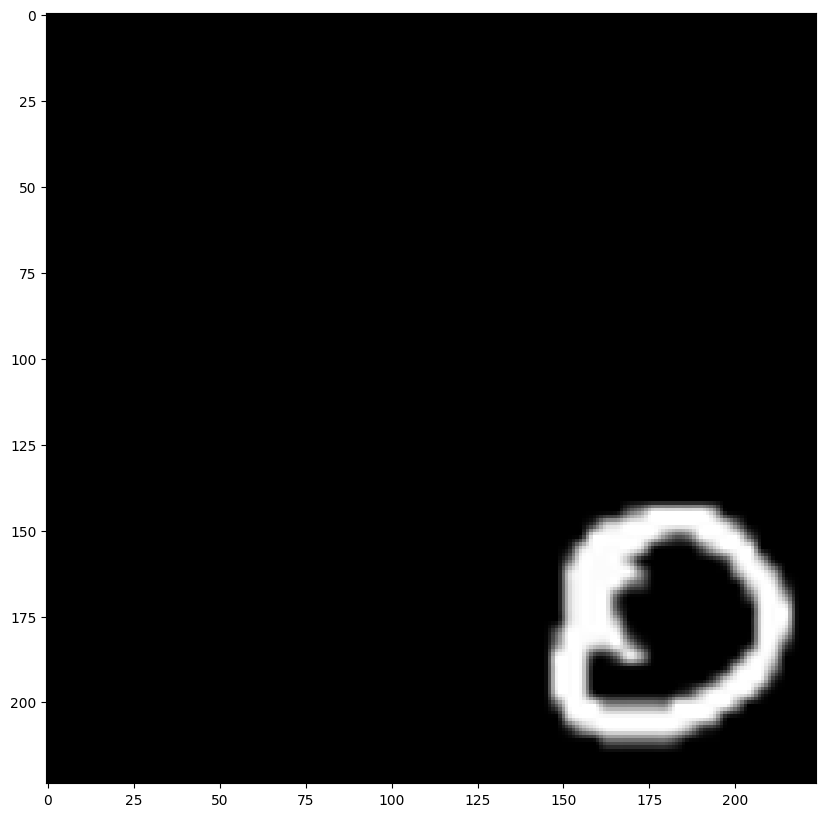

In [4]:
# Check data and labels
someImages = 0
someLabels = 0
i=0
for X,y in train_dl:
    someImages=X
    someLabels=y
    break

for i in range(10,11):
    print(someLabels[i])
    displayImg(someImages[i])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device) #Pretrained or not pretrained??
model.load_state_dict(torch.load('nobiased.pkl'))

Using cuda device


<All keys matched successfully>

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=20,eta_min=0.001,last_epoch=-1)

In [6]:
# train and test function

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
        
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [ ]:
# Begin training
print('The training model is: ',model)
epochs = 50
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

In [19]:
torch.save(model.state_dict(), 'best.pkl')

In [8]:
model.load_state_dict(torch.load('gaussian.pkl'))
test_loss,test_accuracy = test(test_dl,model,loss_fn)
print(test_loss)
print(test_accuracy)

100%|██████████| 34/34 [00:11<00:00,  2.85it/s]

1267.7903289794922
0.5296052631578947


0
model prediction is: tensor([[-22.6530,  22.6221]], device='cuda:0', grad_fn=<AddmmBackward0>)


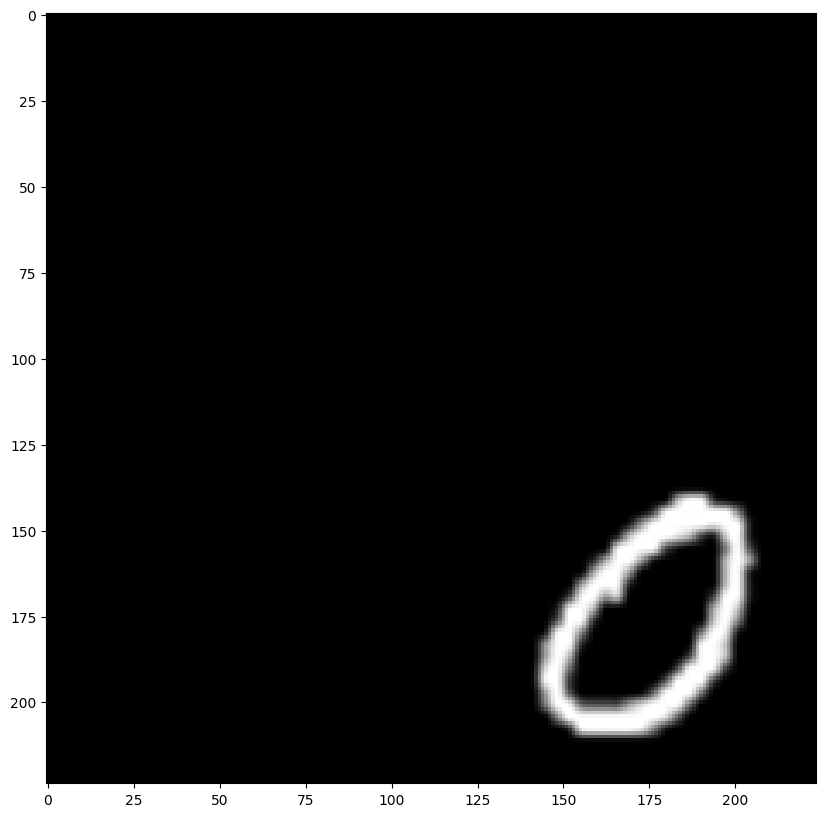

0
model prediction is: tensor([[-22.6885,  22.6525]], device='cuda:0', grad_fn=<AddmmBackward0>)


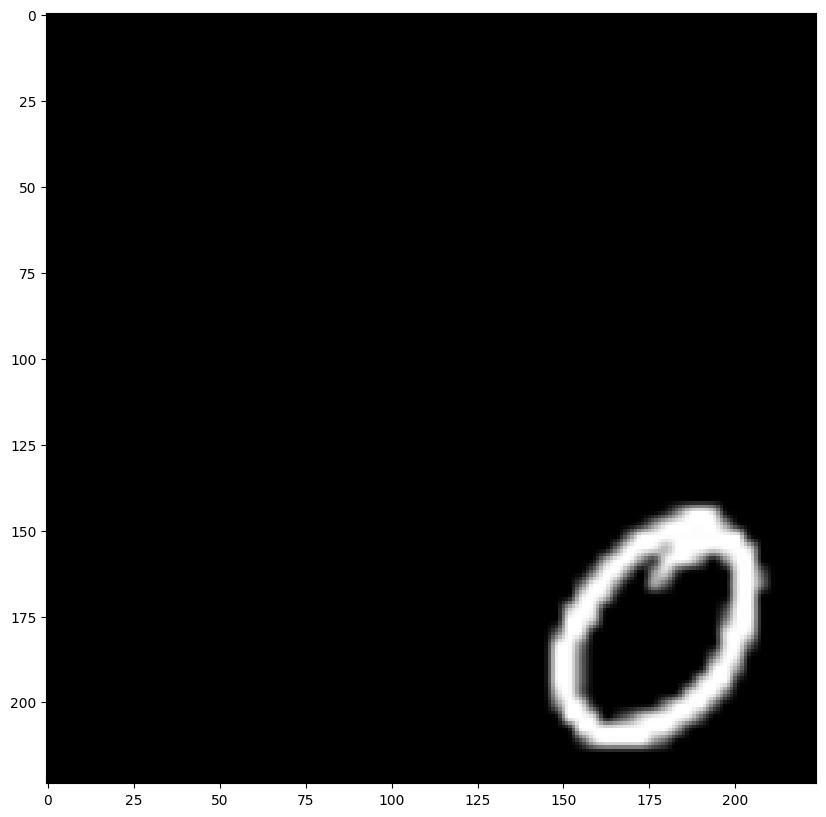

0
model prediction is: tensor([[-22.8227,  22.7366]], device='cuda:0', grad_fn=<AddmmBackward0>)


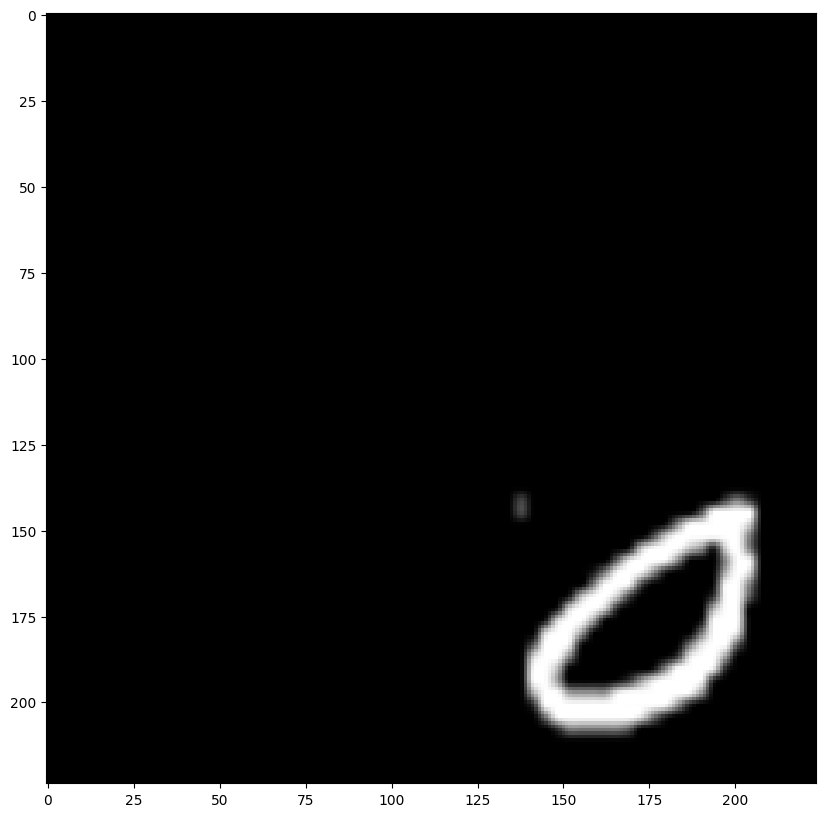

0
model prediction is: tensor([[-22.7198,  22.6746]], device='cuda:0', grad_fn=<AddmmBackward0>)


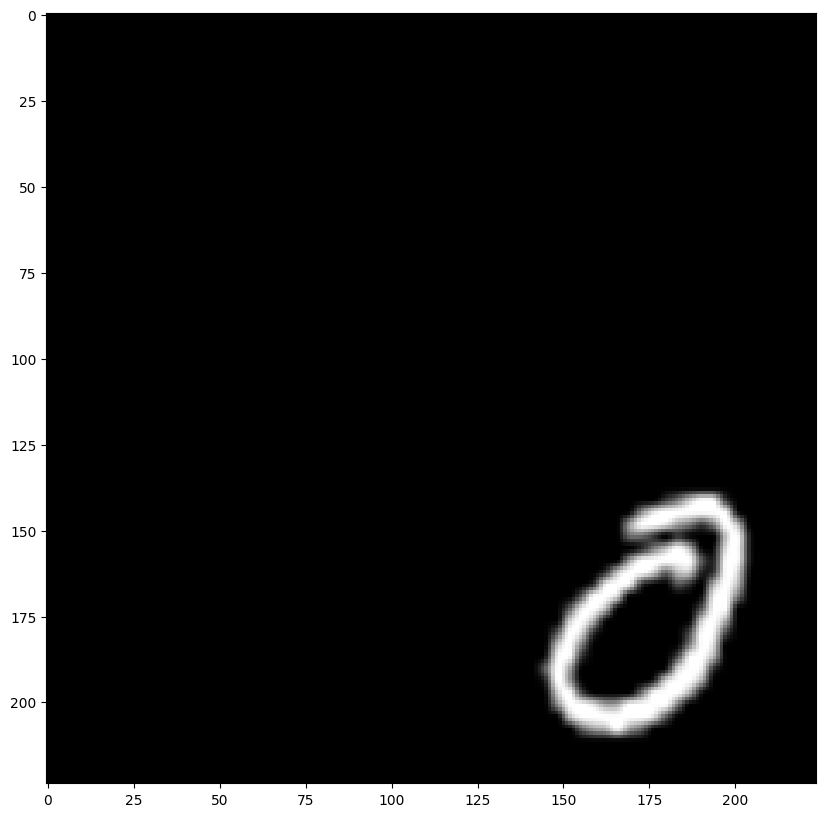

0
model prediction is: tensor([[-22.6338,  22.5728]], device='cuda:0', grad_fn=<AddmmBackward0>)


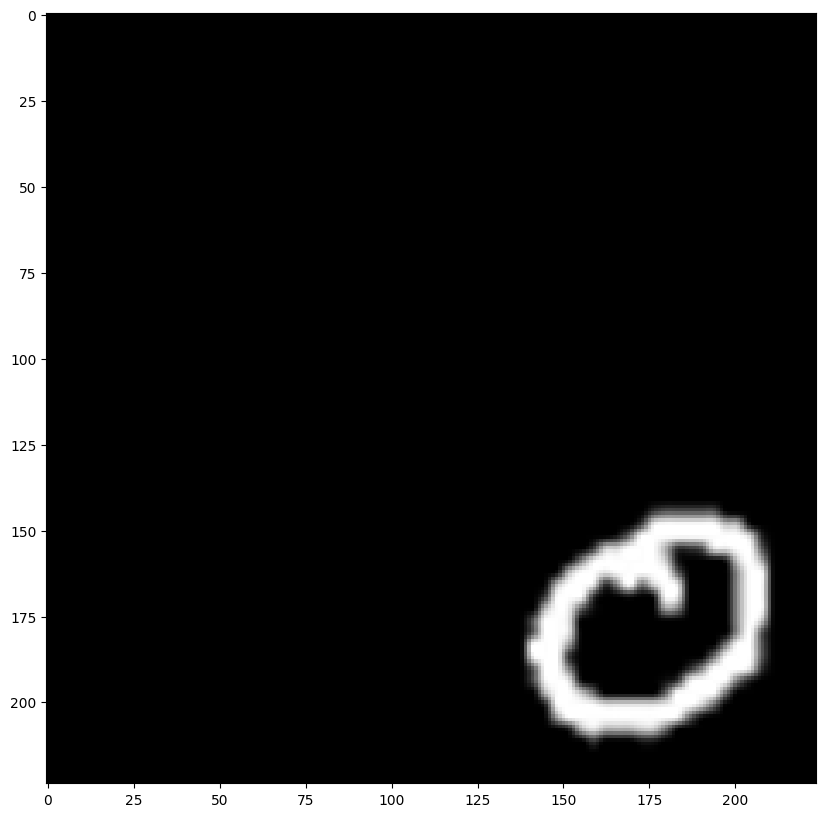

0
model prediction is: tensor([[-23.2480,  23.1647]], device='cuda:0', grad_fn=<AddmmBackward0>)


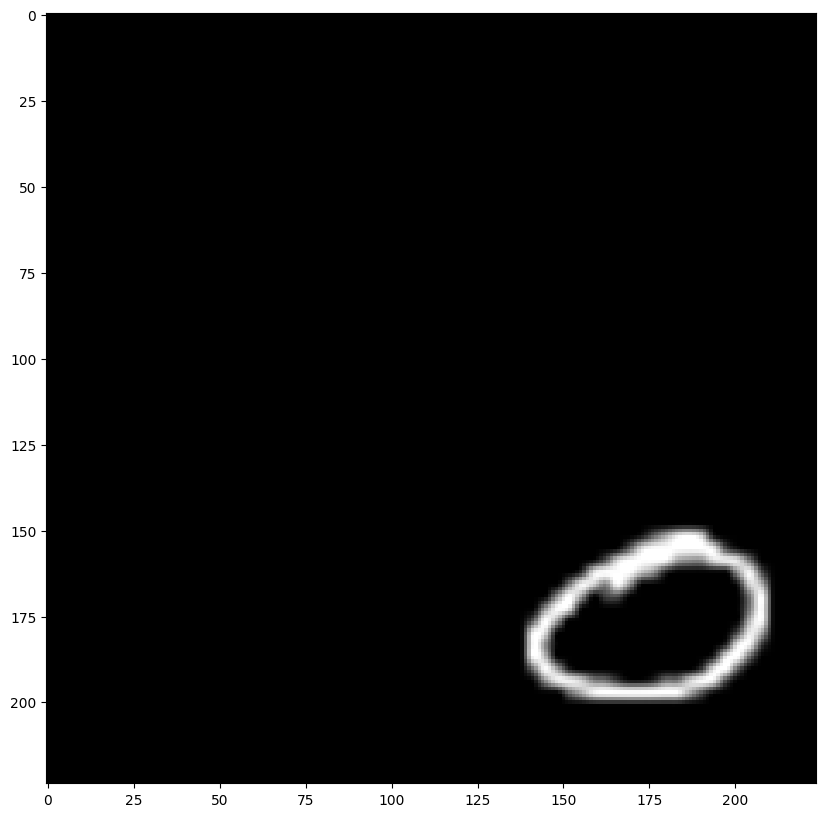

0
model prediction is: tensor([[-22.5313,  22.4698]], device='cuda:0', grad_fn=<AddmmBackward0>)


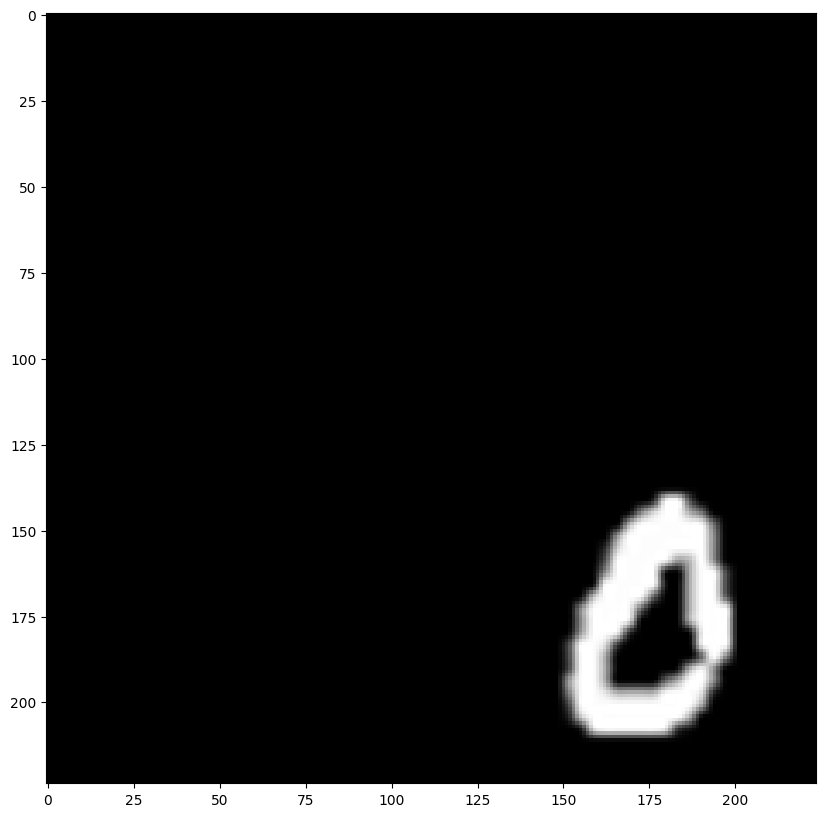

0
model prediction is: tensor([[-22.3683,  22.2943]], device='cuda:0', grad_fn=<AddmmBackward0>)


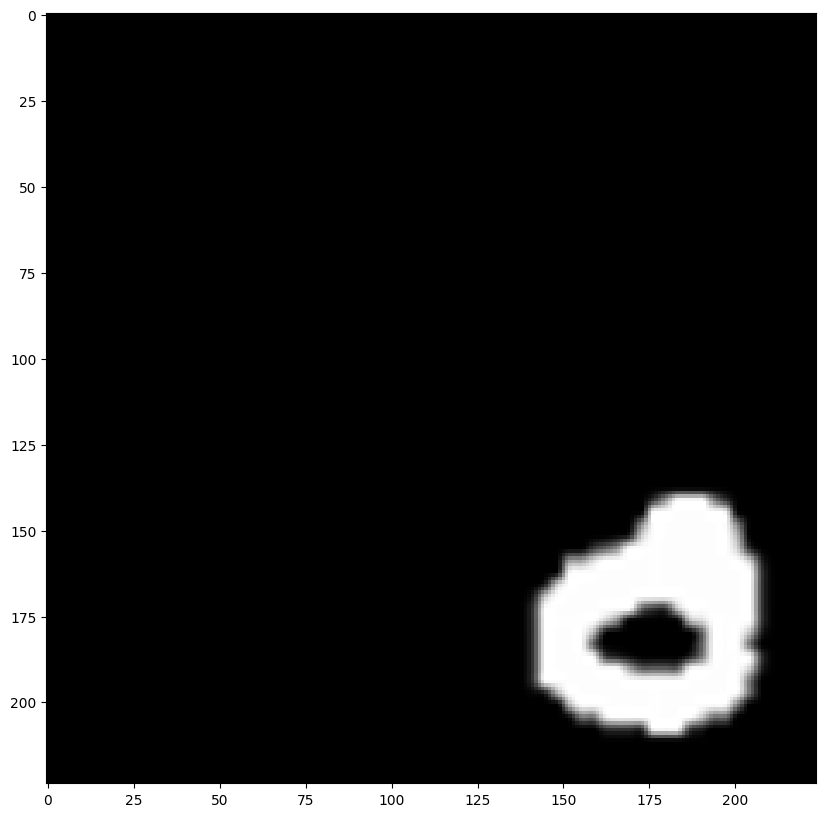

0
model prediction is: tensor([[-23.1392,  23.0571]], device='cuda:0', grad_fn=<AddmmBackward0>)


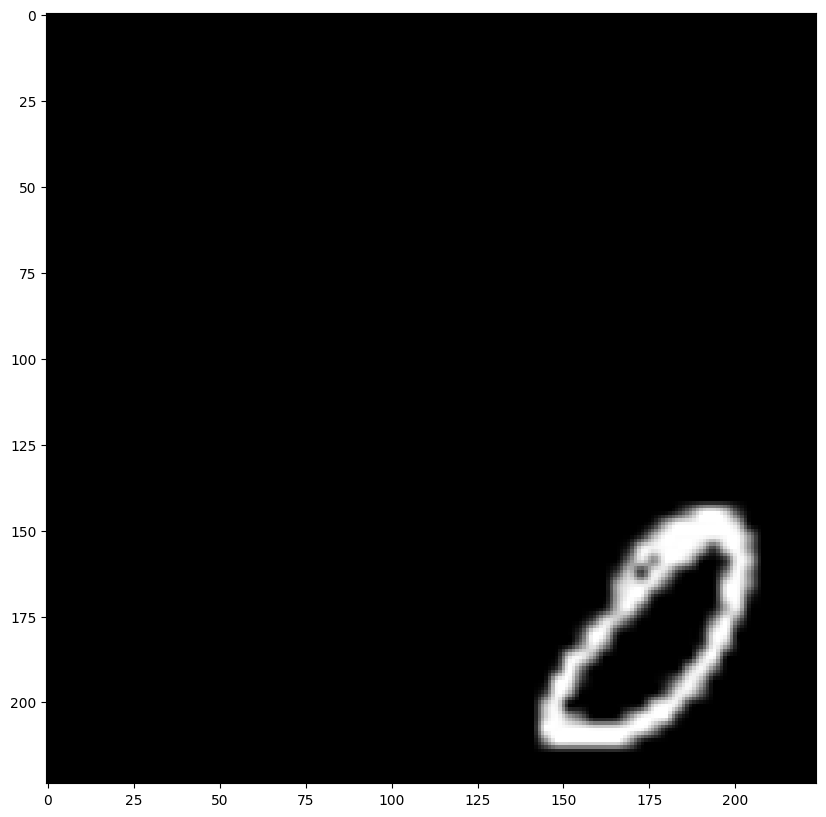

0
model prediction is: tensor([[-22.5907,  22.5665]], device='cuda:0', grad_fn=<AddmmBackward0>)


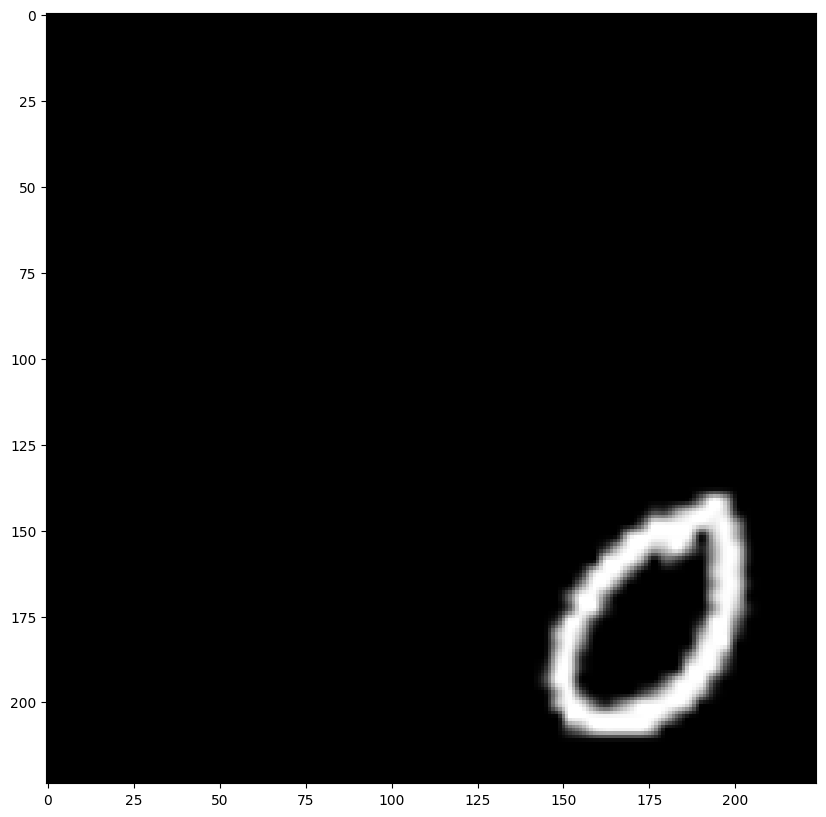

In [9]:
#model.load_state_dict(torch.load('notpretrained.pkl'))
#someImages = 0
#someLabels = 0
#i=0
#for X,y in train_dl:
#    someImages=X
#    someLabels=y
#    break

for i in range(995,1005):
    print(train_ds[i][1])
    print('model prediction is:', model(train_ds[i][0].to(device).reshape(1,3,224,224)))
    displayImg(train_ds[i][0])